## Covariance for each emulator call

We would like to have some intuition for the relative contributions of each training point to each emulator call. This is governed by the covariance kernel, and in this notebook I plan to calculate and plot the covariance between some test point and each training point.

In [46]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
mpl.rcParams['savefig.dpi'] = 140
mpl.rcParams['figure.dpi'] = 140
import numpy as np
# our own modules
import gp_emulator
import p1d_arxiv
import test_simulation

In [2]:
import matplotlib

font = {'size'   : 14}

matplotlib.rc('font', **font)
plt.rcParams["font.family"] = "Times New Roman"
matplotlib.rcParams['mathtext.fontset'] = 'cm'

In [3]:
# specify simulation to use to generate synthetic data
test_sim_label=None
if type(test_sim_label)==int:
    drop_sim_number=test_sim_label
    print('will drop sim number {} from emulator'.format(drop_sim_number))
else:
    drop_sim_number=None
# specify simulation suite and P1D mesurements
basedir="/p1d_emulator/sim_suites/Australia20/"
skewers_label='Ns500_wM0.05'
p1d_label=None
z_max=4.0

In [4]:
# Set up emulator training set
z_max=4
arxiv=p1d_arxiv.ArxivP1D(basedir=basedir,drop_sim_number=drop_sim_number,
                            drop_tau_rescalings=True,z_max=z_max,
                            drop_temp_rescalings=True,skewers_label=skewers_label)

In [5]:
## Build emulator
paramList=['mF', 'sigT_Mpc', 'gamma', 'kF_Mpc', 'Delta2_p', 'n_p']
# specify k range
kmax_Mpc=8
emu=gp_emulator.GPEmulator(basedir,p1d_label,skewers_label,z_max=z_max,
                                verbose=False,paramList=paramList,train=False,
                                emu_type="k_bin",passArxiv=arxiv,
                                kmax_Mpc=kmax_Mpc)
emu.load_default()

 /home/chris/.local/lib/python3.8/site-packages/paramz/parameterized.py:61: RuntimeWarning:Don't forget to initialize by self.initialize_parameter()!


### Plotting the covariance for each training point

Generate some random emulator call. Lets start with some reasonable values for now, i.e. the central fiducial sim.

Now for an emulator call we want to:
1. Calculate the covariance between that point and each training point
2. Plot a 2D projection of this emulator call and the training points
3. Color each training point by the covariance, and we can split this by kernel

In [6]:
## Set up test simulation object
test_sim=test_simulation.TestSimulation(sim_label="central",
            basedir=basedir,skewers_label=skewers_label,z_max=z_max,kmax_Mpc=kmax_Mpc,kp_Mpc=arxiv.kp_Mpc)
emu_call_dict=test_sim.get_emulator_calls(3)
emu_call=emu.return_unit_call(emu_call_dict)

In [7]:
## Add this parameter vector to the X training data
emu_call=np.expand_dims(emu_call,axis=0) ## Expand number of dimensions to match X grid

## The following is essentially a list of parameter vectors
## The first entry is the test point defined above
## The remining entries are the position vectors for each training point
## Have to do it this way as GPy doesn't allow individual calculations of the
## covariances apparently
test_and_training=np.concatenate((emu_call,emu.X_param_grid),axis=0)

In [8]:
## Now calculate the covariance
## Linear only
C_lin=emu.gp.kern.linear.K(test_and_training)

## RBF only
C_rbf=emu.gp.kern.rbf.K(test_and_training)

## Full kernel
C_full=emu.gp.kern.K(test_and_training)

In [31]:
## Select parameters along which to project
param1="n_p"
param2="Delta2_p"

emu_data=arxiv.data
Nemu=len(emu_data)

emu_1=np.empty(Nemu)
emu_2=np.empty(Nemu)

cov_lin=np.empty(Nemu)
cov_rbf=np.empty(Nemu)
cov_full=np.empty(Nemu)

for aa in range(Nemu):
    emu_1[aa]=emu_data[aa][param1]
    emu_2[aa]=emu_data[aa][param2]
    ## Covariance for each point
    cov_rbf[aa]=C_rbf[0][aa+1]
    cov_lin[aa]=C_lin[0][aa+1]
    cov_full[aa]=C_full[0][aa+1]

    
## Point where the emu calls were made
call_1=emu_call_dict[param1]
call_2=emu_call_dict[param2]

In [32]:
## Select colourmap
cmap=cm.BuPu

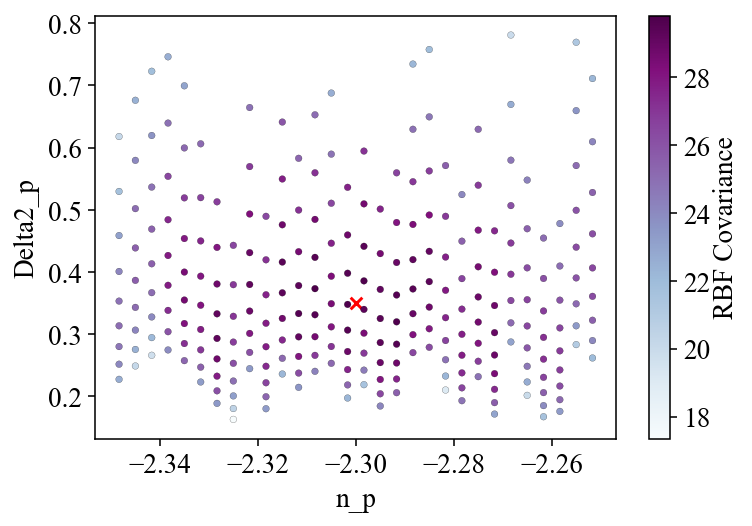

In [33]:
zmin=min(cov_rbf)
zmax=max(cov_rbf)

plt.scatter(call_1,call_2,c="red",marker="x",vmin=zmin, vmax=zmax)
plt.scatter(emu_1,emu_2,c=cov_rbf,s=12,vmin=zmin, vmax=zmax,cmap=cmap,edgecolor="black",linewidth=0.1)
cbar=plt.colorbar()
cbar.set_label("RBF Covariance", labelpad=+1)
plt.xlabel(param1)
plt.ylabel(param2)
plt.show()

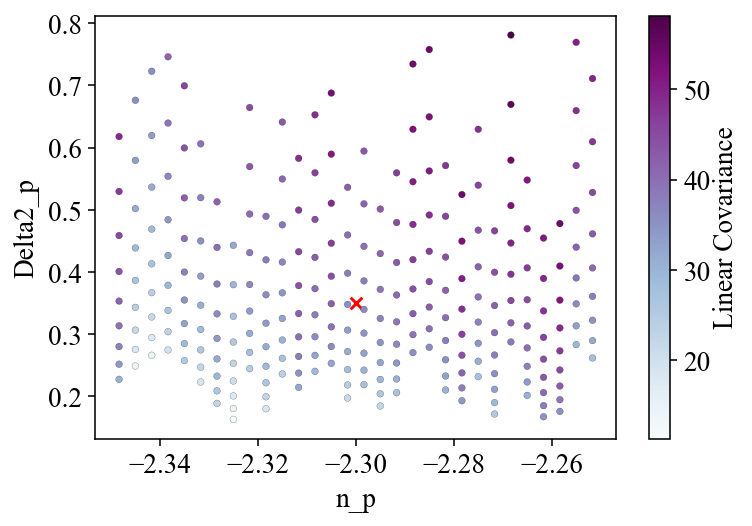

In [34]:
zmin=min(cov_lin)
zmax=max(cov_lin)

plt.scatter(call_1,call_2,c="red",marker="x",vmin=zmin, vmax=zmax)
plt.scatter(emu_1,emu_2,c=cov_lin,s=12,vmin=zmin, vmax=zmax,cmap=cmap,edgecolor="black",linewidth=0.1)
cbar=plt.colorbar()
cbar.set_label("Linear Covariance", labelpad=+1)
plt.xlabel(param1)
plt.ylabel(param2)
plt.show()

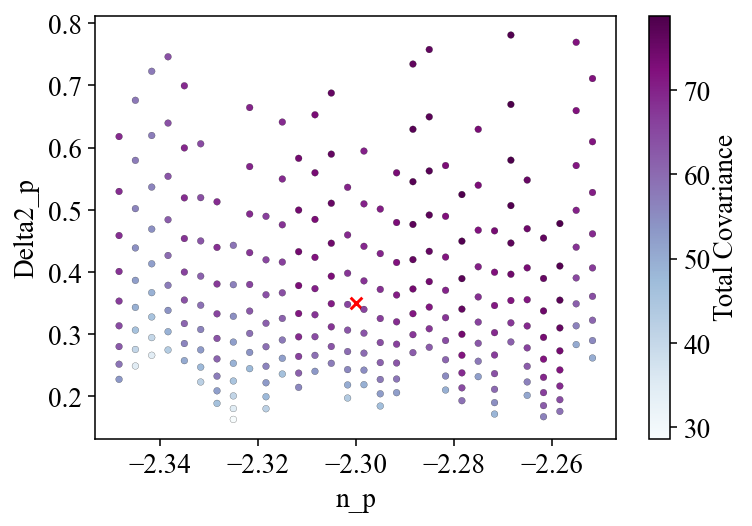

In [35]:
zmin=min(cov_full)
zmax=max(cov_full)

plt.scatter(call_1,call_2,c="red",marker="x",vmin=zmin, vmax=zmax)
plt.scatter(emu_1,emu_2,c=cov_full,s=12,vmin=zmin, vmax=zmax,cmap=cmap,edgecolor="black",linewidth=0.1)
cbar=plt.colorbar()
cbar.set_label("Total Covariance", labelpad=+1)
plt.xlabel(param1)
plt.ylabel(param2)
plt.show()

### Relative contributions

This might not be the best quantity to represent the relative significance of each training point. From eq (2.19) of Rasmussen & Williams, the mean of the PPD for test point $f_\star$ at $X_\star$ is given by:

$$\bar{f_\star}=K(X_\star,X)K(X,X)^{-1}\mathbf{f}$$

and in the previous plots I'm showing $K(X_\star,X)$. Next let's plot the full coefficient for each training point, which will define as $W$ just for the purposes of this code, $W(X_\star,X)\equiv K(X_\star,X)K(X,X)^{-1}$.

In [36]:
cmap=cm.PiYG

In [37]:
K_inv_rbf=np.linalg.inv(C_rbf)
K_inv_lin=np.linalg.inv(C_lin)
K_inv_full=np.linalg.inv(C_full)

W_rbf=C_rbf[0]*K_inv_rbf
W_lin=C_lin[0]*K_inv_lin
W_full=C_full[0]*K_inv_full

In [38]:
ppd_weight_rbf=np.empty(Nemu)
ppd_weight_lin=np.empty(Nemu)
ppd_weight_full=np.empty(Nemu)

for aa in range(Nemu):
    ppd_weight_rbf[aa]=W_rbf[0][aa+1]
    ppd_weight_lin[aa]=W_lin[0][aa+1]
    ppd_weight_full[aa]=W_full[0][aa+1]

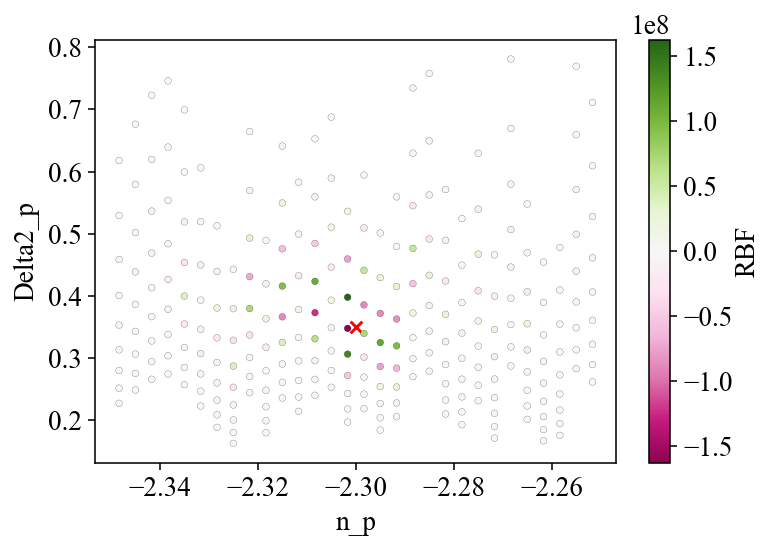

In [39]:
zmax=max(ppd_weight_rbf)
zmin=-1.*zmax


plt.scatter(call_1,call_2,c="red",marker="x",vmin=zmin, vmax=zmax)
plt.scatter(emu_1,emu_2,c=ppd_weight_rbf,s=12,vmin=zmin, vmax=zmax,cmap=cmap,edgecolor="black",linewidth=0.1)
cbar=plt.colorbar()
cbar.set_label("RBF", labelpad=+1)
plt.xlabel(param1)
plt.ylabel(param2)
plt.show()

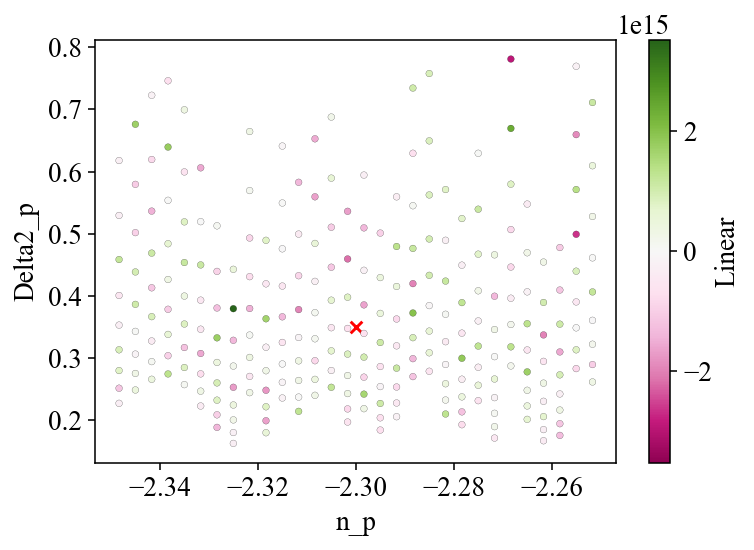

In [40]:
zmax=max(ppd_weight_lin)
zmin=-1.*zmax

plt.scatter(call_1,call_2,c="red",marker="x",vmin=zmin, vmax=zmax)
plt.scatter(emu_1,emu_2,c=ppd_weight_lin,s=12,vmin=zmin, vmax=zmax,cmap=cmap,edgecolor="black",linewidth=0.1)
cbar=plt.colorbar()
cbar.set_label("Linear", labelpad=+1)
plt.xlabel(param1)
plt.ylabel(param2)
plt.show()

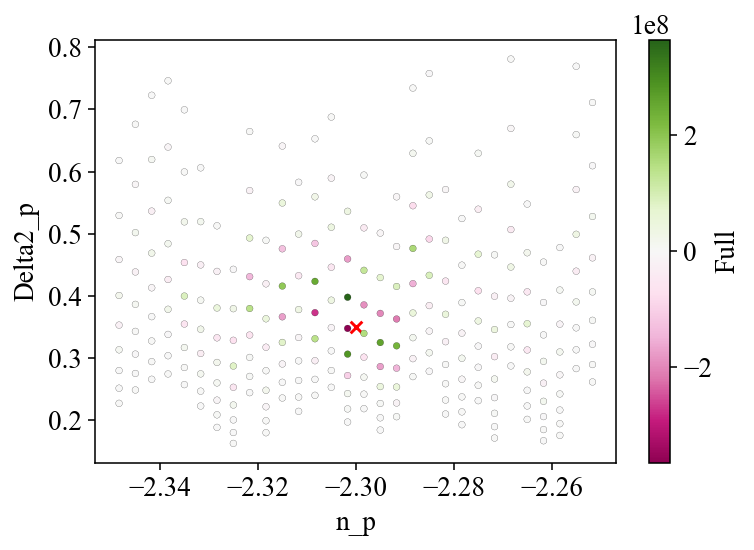

In [41]:
zmax=max(ppd_weight_full)
zmin=-1.*zmax

plt.scatter(call_1,call_2,c="red",marker="x",vmin=zmin, vmax=zmax)
plt.scatter(emu_1,emu_2,c=ppd_weight_full,s=12,vmin=zmin, vmax=zmax,cmap=cmap,edgecolor="black",linewidth=0.1)
cbar=plt.colorbar()
cbar.set_label("Full", labelpad=+1)
plt.xlabel(param1)
plt.ylabel(param2)
plt.show()